In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, random_split
from utils import tokenizer, Collator
from data import AGNewsDataset
%load_ext autoreload
%autoreload 2


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
torch.cuda.empty_cache()

In [4]:
agnews = AGNewsDataset(text="Description")
agnews_train, agnews_valid = random_split(agnews, lengths=[20000, 100_000])

In [5]:
import re

def clean_text(text: str):
    text = text.lower().strip()
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z!?]+", r" ", text)
    return text

def yield_tokens(dataset, tokenizer=tokenizer):
    for row in tqdm(dataset):
        yield tokenizer(clean_text(row[-1]))

In [6]:
PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<pad>", "<unk>", "<bos>", "<eos>"]
vocab = build_vocab_from_iterator(
    yield_tokens(agnews_train), min_freq=1, specials=special_symbols, special_first=True)
vocab.set_default_index(UNK_IDX)

100%|██████████| 20000/20000 [00:02<00:00, 7712.09it/s]


In [7]:
collate = Collator(vocab=vocab)

### with attn

In [8]:
train_loader = DataLoader(agnews_train, batch_size=24, shuffle=True, collate_fn=collate)

In [10]:
next(iter(train_loader))[-1].shape

torch.Size([24, 59])

In [13]:
import torch.optim as optim
from model import RVAE
from trainer import RVAETrainer

rvae = RVAE(
    vocab_size=len(vocab),
    embedding_size=256,
    hidden_size=128,
    latent_size=32,
    with_att=True,
    device=device,
).to(device)
optimizer = optim.Adam(rvae.parameters(), lr=8e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="mean")
trainer = RVAETrainer(
    model=rvae,
    optimizer=optimizer,
    verbose_period=1,
    device=device,
    params={"loc": 3e3, "scale": 6e2},
)

In [14]:
trainer.fit(7, train_loader)

epoch 6: 100%|██████████| 834/834 [02:04<00:00,  6.70batch/s, kl_loss=0.0638, reconstr_loss=4.92] 


In [15]:
torch.cuda.empty_cache()

In [16]:
rvae.eval()

RVAE(
  (embedding): Embedding(29419, 256, padding_idx=0, max_norm=1)
  (encoder): EncoderRNN(
    (embedding): Embedding(29419, 256, padding_idx=0, max_norm=1)
    (gru): GRU(256, 128, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(29419, 256, padding_idx=0, max_norm=1)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=128, out_features=128, bias=True)
      (Ua): Linear(in_features=128, out_features=128, bias=True)
      (Va): Linear(in_features=128, out_features=1, bias=True)
    )
    (gru): GRU(384, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=29419, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (hidden2mu): Linear(in_features=128, out_features=32, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=32, bias=True)
  (latent2hidden): Linear(in_features=32, out_features=128, bias=True)
)

In [17]:
_, encoder_inputs = next(iter(train_loader))
encoder_inputs = encoder_inputs.to(device)
logits, _, _ = rvae(encoder_inputs)


In [18]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(encoder_inputs[i].tolist())))

ap canada s largest cable company rogers communications inc said monday it will pay billion for the percent stake in rogers wireless communications inc owned by longtime american partner at amp t wireless services inc <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
west lafayette in the orange put together a nice drive to end the first half but came away empty as senior receiver jared jones could nt handle a low snap on a yard field goal attempt with seconds remaining in the half <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
two people were killed and five wounded when a bomb exploded in indonesia s central sulawesi province yesterday a police spokesman said the blast happened in front of a market in the town of poso <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [19]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(logits.argmax(dim=-1)[i].tolist())))

ap canada s largest co company whose inc inc said on s will be to to the internet of of the wireless communications and said the wireless wireless general and <eos> t gt fullquote n said the services <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
west mw in the orange put from a to came to a off man touchdown of killed with <eos> in the first <eos> jones <eos> to to a <eos> season <eos> <eos> two days <eos> <eos> to a or <eos> the way <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
two people were killed and the a one the to exploded in a s defense of stadium yesterday <eos> to and yesterday <eos> two the over the s the <eos> in the the of the <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>

In [20]:
dataloader = DataLoader(agnews_train, batch_size=32, shuffle=False, collate_fn=collate)

In [21]:
torch.cuda.empty_cache()

In [30]:
import numpy as np

label_list = []
mu_list = []
with torch.no_grad():
    for label, encoder_inputs in tqdm(dataloader):
        encoder_inputs = encoder_inputs.to(device)
        _, mu, logvar = rvae(encoder_inputs)
        label_list.append(label)
        mu_list.append(mu.permute((1, 0, 2)).contiguous().view(32, -1))

mus = torch.cat(mu_list, dim=0)
labels = []
for elem in label_list:
    labels += elem
labels = np.array(labels)

100%|██████████| 625/625 [00:25<00:00, 24.95it/s]


In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mus_tsne = tsne.fit_transform(mus.cpu().numpy())

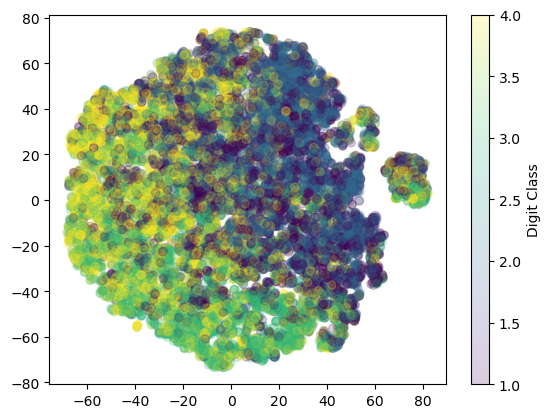

In [35]:
import matplotlib.pyplot as plt

plt.scatter(mus_tsne[:, 0], mus_tsne[:, 1], alpha=0.2, 
            c=labels)
plt.colorbar(label='Digit Class')

### without attn

In [16]:
train_loader = DataLoader(agnews_train, batch_size=18, shuffle=True, collate_fn=collate)

In [17]:
import torch.optim as optim
from model import RVAE
from trainer import RVAETrainer

rvae = RVAE(
    vocab_size=len(vocab),
    embedding_size=256,
    hidden_size=128,
    latent_size=32,
    with_att=False,
    device=device,
    num_layers=2
).to(device)
optimizer = optim.Adam(rvae.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="mean")
trainer = RVAETrainer(
    model=rvae,
    optimizer=optimizer,
    verbose_period=1,
    device=device,
    params={"loc": 3e3, "scale": 6e2},
)

In [18]:
trainer.fit(5, train_loader)

epoch 4: 100%|██████████| 1112/1112 [02:35<00:00,  7.14batch/s, kl_loss=0.187, reconstr_loss=4.54]


In [19]:
torch.cuda.empty_cache()

In [20]:
rvae.eval()
_, encoder_inputs = next(iter(train_loader))
encoder_inputs = encoder_inputs.to(device)
logits, _, _ = rvae(encoder_inputs)


In [21]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(encoder_inputs[i].tolist())))

abu hamza the radical muslim cleric is to face terrorism charges in the uk delaying us extradition proceedings and upsetting the american authorities who wanted to try him for separate offences <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
los angeles reuters video game accessory maker mad catz interactive inc will release a series of game related products based on disney properties starting with the incredibles mad catz chief executive darren richardson said on wednesday <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
flowery branch ga sports network the atlanta falcons monday signed pro bowl tight end alge crumpler to a six year contract extension <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [22]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(logits.argmax(dim=-1)[i].tolist())))

abu hamza the cleric cleric cleric who investigating stand the to against the al s al security and against the the us government who was to be to to the <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
san angeles reuters the entertainment of maker has catz has inc said be a new of digital against to for on monday co and on the company of co said executive <eos> catz said <eos> tuesday <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
knoxville sports sports sports network the cleveland falcons signed signed a brands line contract to crumpler to a victory year <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
saudi quote lines systems warned its in been a latest of i

In [21]:
z = torch.randn(1, 2, 32).to(device)
# z = mu[0] + logvar[0].exp().sqrt() * z
hidden = rvae.latent2hidden(z).permute((1, 0, 2)).contiguous()

generation_frame = torch.Tensor(1, 128)

logits, _, _ = rvae.decoder(generation_frame, hidden)

" ".join(vocab.lookup_tokens(
    logits.argmax(dim=-1)[0].tolist()
))


'new york the world s top team has been a new record in the world s first round of the year and the world s top team is expected to be the first time <eos> <eos> <eos> <eos> from the world <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>'

In [23]:
dataloader = DataLoader(agnews_train, batch_size=32, shuffle=False, collate_fn=collate)

In [24]:
import numpy as np
torch.cuda.empty_cache()

label_list = []
mu_list = []
with torch.no_grad():
    for label, encoder_inputs in tqdm(dataloader):
        encoder_inputs = encoder_inputs.to(device)
        _, mu, logvar = rvae(encoder_inputs)
        label_list.append(label)
        mu_list.append(mu.permute((1, 0, 2)).contiguous().view(32, -1))

mus = torch.cat(mu_list, dim=0)
labels = []
for elem in label_list:
    labels += elem
labels = np.array(labels)

100%|██████████| 625/625 [00:18<00:00, 33.41it/s]


In [25]:
mus.shape

torch.Size([20000, 128])

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mus_tsne = tsne.fit_transform(mus.cpu().numpy())

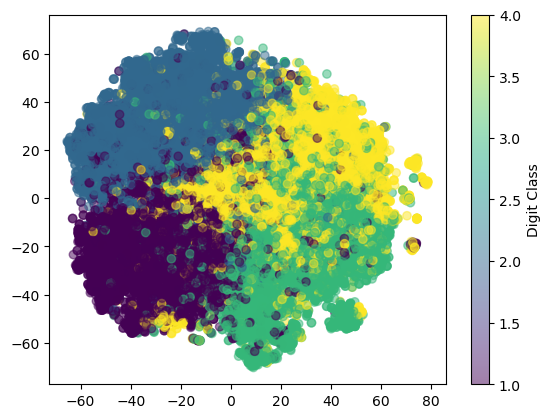

In [27]:
import matplotlib.pyplot as plt

plt.scatter(mus_tsne[:, 0], mus_tsne[:, 1], alpha=0.5, 
            c=labels)
plt.colorbar(label='Digit Class')

# 1-4: world, sport, business, sci/tech